[*********************100%%**********************]  1 of 1 completed
C:\Users\hanss\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0819 - val_loss: 0.0108
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0140 - val_loss: 0.0060
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0109 - val_loss: 0.0048
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0092 - val_loss: 0.0048
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0086 - val_loss: 0.0057
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0074 - val_loss: 0.0044
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0062 - val_loss: 0.0044
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


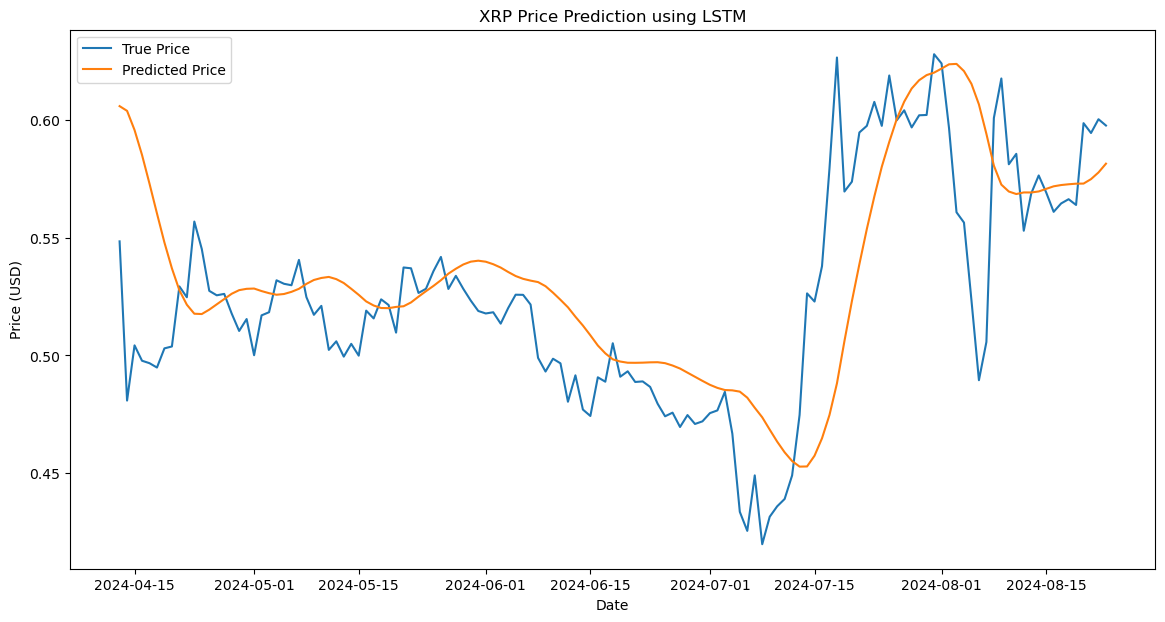

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt  # Ensure matplotlib is imported

# Fetch historical data
ticker_symbol = "XRP-USD"
xrp_data = yf.download(ticker_symbol, start="2022-01-01", end="2024-08-24")

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(xrp_data['Close'].values.reshape(-1, 1))

# Prepare Training and Testing Datasets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Create a dataset with 60 timesteps and 1 output
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Predict future prices
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Adjust the test data shape to match predicted prices
true_prices = scaler.inverse_transform(test_data[60:len(predicted_prices) + 60])

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(xrp_data.index[-len(predicted_prices):], true_prices, label="True Price")
plt.plot(xrp_data.index[-len(predicted_prices):], predicted_prices, label="Predicted Price")
plt.title('XRP Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
